### Importing libraries.

You will need to install: _opencv, numpy, matplotlib, sklearn, tqdm, and scipy._

In [1]:
import os
import glob
from random import randint
from typing import List, Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import rotate

from nn.NeuralNetwork import NeuralNetwork

### Let's give a quick look to the implemented code.

Network supports:
- specifying _input_ and _output_ features count.
- vary the amount of hidden layers by supplying a tuple (_use empty for no hidden layers).
- 2 different activation functions: _ReLU_ and _Sigmoid_.
- different weights initialisation heuristics. Use _He_ for _ReLU_ and _Xavier_ for _Sigmoid_.

In [2]:
model = NeuralNetwork(in_features=10, out_features=5, hidden_layers=(10,))
model

[
	Weights(10, 10)
	ReLU
	Weights(10, 5)
	Softmax
]

In [3]:
preds = model.forward(
    np.array([
        [0.1, 1.0, 5.5, -7, 3.3, 1.1, 4, 3.2, 9.9, 0],
        [0.2, -1.2, 11.5, -70, 31.3, 12.1, 7, -1.2, 4.9, 2],
    ])
)

print("Output shape:", preds.shape)
print("Predictions:", preds)

# Sanity check, should sum to 1.0 as last layer is softmax.
print("Prob sums:", np.sum(preds, axis=1))

Output shape: (2, 5)
Predictions: [[9.99554309e-01 6.33930184e-11 4.42362515e-04 3.19470621e-06
  1.33570807e-07]
 [1.00000000e+00 3.51648413e-50 1.34031312e-13 2.54537479e-29
  2.74624384e-44]]
Prob sums: [1. 1.]


### Working with real dataset.

Let's take it to the next level and try to train the network on a more complicated dataset.
I will be using classical [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

**MNIST** dataset has the following properties:
- images are vectors of size _784_, which are flattened _28x28_ 2 dimensional grayscale pictures.
- image pixel is in **[0, 255]**, where **black areas (closer to 0)** correspond to background and **white areas (closer to 255)** correspond to digits.
- labels are strings.

In [4]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [5]:
def display_dataset(n_rows: int,
                    n_cols: int,
                    X: np.ndarray,
                    y: np.ndarray,
                    split_title: str="",
                    pred: Optional[np.ndarray]=None,
                    figsize: [int, int]=(12, 12)):    
    indices = np.random.choice(range(X.shape[0]), n_rows * n_cols, replace=False)
    _, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    for ridx, didx in enumerate(indices):
        gi = ridx // n_cols
        gj = ridx % n_cols
        
        axarr[gi, gj].imshow(
            X[didx].reshape(28, 28),
            interpolation="nearest",
        )
        title = f"Digit: {y[didx]}"
        if pred is not None:
            title = f"Digit: {y[didx]}\nPredicted: {pred[didx]}"

        axarr[gi, gj].set_title(title)
        axarr[gi, gj].axis("off")
    
    plt.suptitle(f"MNIST 784 random {split_title} {n_rows * n_cols} samples")
    plt.show()

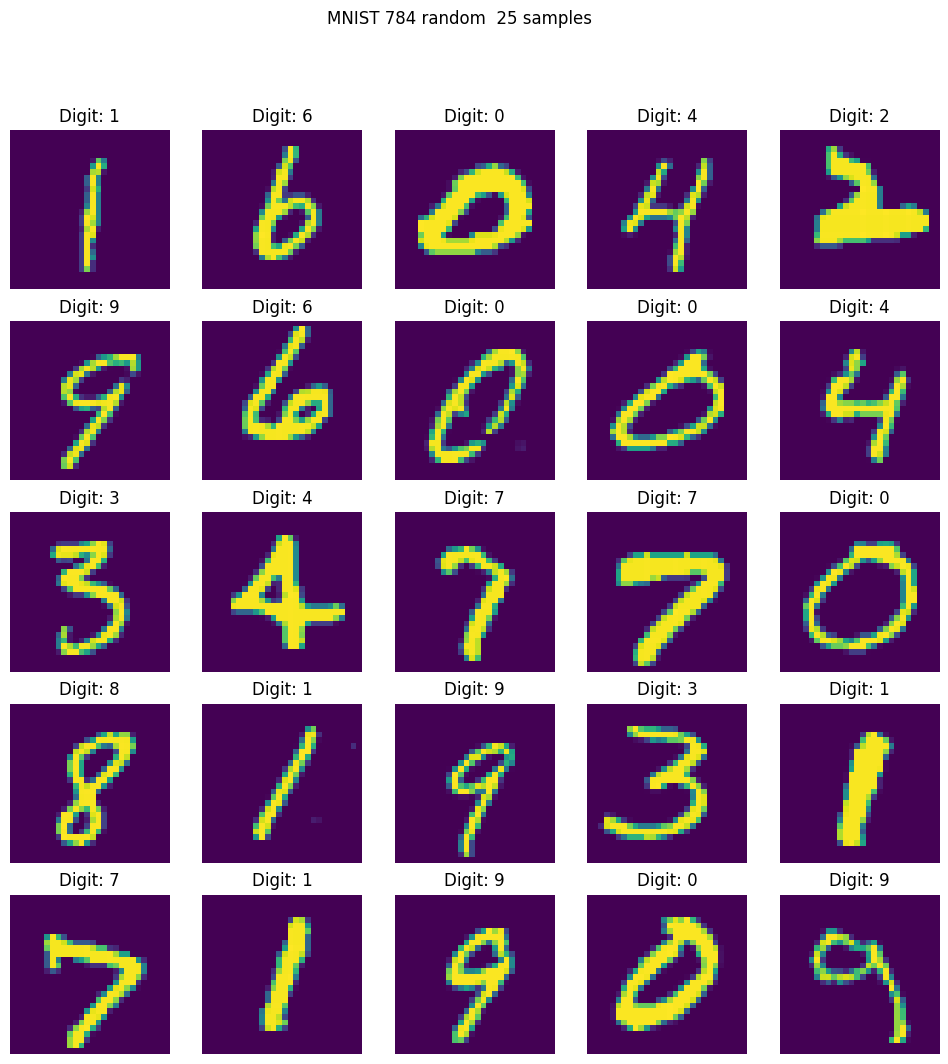

In [6]:
display_dataset(
    n_rows=5,
    n_cols=5,
    X=X,
    y=y,
)

### Data augmentation.

A small augmentation will not hurt the dataset.
Let's rotate **15%** of the dataset for an angle in **[-10, 10] degrees range**.

In [7]:
def augment(X: np.ndarray,
            from_angle: float,
            to_angle: float) -> np.ndarray:
    X_aug = np.zeros_like(X)

    for i in range(X.shape[0]):
        X_aug[i, :] = rotate(X[i, :].reshape(28, 28), angle=randint(from_angle, to_angle), reshape=False).reshape((1, 784))

    return X_aug

In [8]:
X_aug_size = int(X.shape[0]*0.15)
X_aug_idx = np.random.permutation(X.shape[0])[0:X_aug_size]
X_aug = augment(X[X_aug_idx], from_angle=-10, to_angle=10)

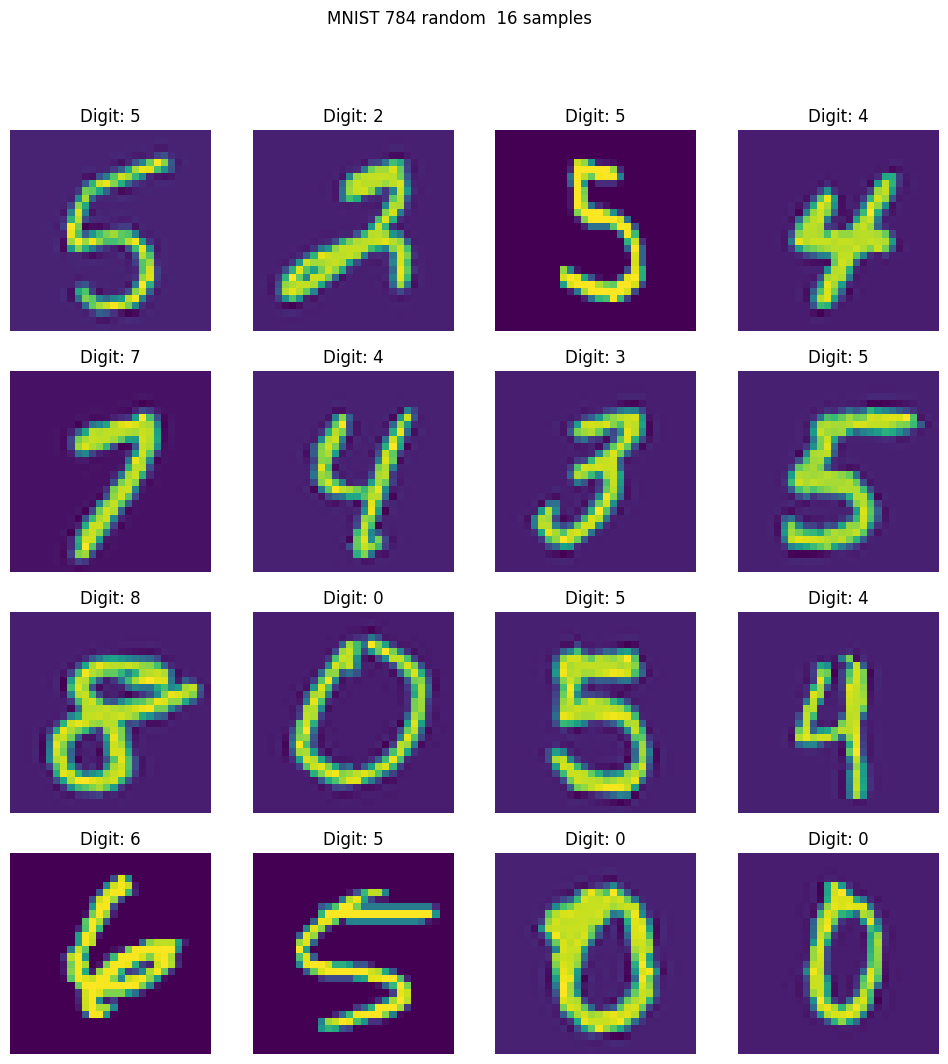

In [9]:
display_dataset(
    n_rows=4,
    n_cols=4,
    X=X_aug,
    y=y[X_aug_idx],
)

In [10]:
# Updating the original dataset.
X = np.vstack((X, X_aug))
y = np.hstack((y, y[X_aug_idx]))

print("New size is:", X.shape[0])

New size is: 80500


### A few more utility methods.

As long as **MNIST** provides labels as array of strings but the network predicts classes probabilities vector, we need a method to convert class tag to a probabilities vector.

For instance,
- for tag **1** the vector is **[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]**,
- for tag **3** the vector is **[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]**,

_and so on_

In [11]:
def class_to_vector(raw_classes: List[str]) -> np.ndarray:
    y_true = np.zeros((len(raw_classes),10))
    for i, raw_class in enumerate(raw_classes):
        y_true[i, int(raw_class)] = 1
    return y_true

### Declaring loss function and its gradients.

Loss function is **cross entropy**:

\begin{eqnarray}
\frac{1}{n} \sum_{n \in N} y_{true} * log(y_{pred})
\end{eqnarray}

Its derivative is provided below (for a single object) and implemented in _grad_loss_fn_.

\begin{eqnarray}
\frac{-y_{true}}{y_{pred}}
\end{eqnarray}

Though it leads the gradient to explode when the _y_pred_ is _small_, therefore during the training phase _simplified_grad_loss_fn_ is used, which is:

\begin{eqnarray}
\frac{y_{pred}-y_{true}}{N}
\end{eqnarray}

In [12]:
def loss_fn(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    return -np.mean(np.sum(np.multiply(y_true, np.log(y_pred + eps)), axis=1))

In [13]:
def grad_loss_fn(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    batch_size = y_true.shape[0]
    return (-y_true / (y_pred + eps)) / batch_size

In [14]:
def simplified_grad_loss_fn(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    batch_size = y_true.shape[0]
    return (y_pred - y_true) / batch_size

We will split dataset into:
- **train**: training on this split.
- **val**: checking accuracy on val.
- and **test**: using as the last resort split, discarding the model if not happy with results.

In [15]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, train_size=0.8)

In [16]:
def obtain_accuracy_on(model: NeuralNetwork,
                       X: np.ndarray,
                       y: np.ndarray) -> float:
    y_true = class_to_vector(y)
    y_pred = model.forward(X / 255.0)
    
    accuracy = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
    return accuracy / X.shape[0]


def train(model: NeuralNetwork,
          X_train: np.ndarray,
          y_train: np.ndarray,
          X_val: np.ndarray,
          y_val: np.ndarray,
          epochs: int=100,
          batch_size: int=8,
          lr: float=0.1) -> [np.ndarray, np.ndarray, np.ndarray]:    
    train_losses = []
    train_accuracies = []

    val_accuracies = []
    
    for epoch in tqdm(range(epochs)):    
        indices = np.random.permutation(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]
    
        assert X_train.shape[0] == y_train.shape[0],\
            "Both X and y train should stay the same"
    
        epoch_losses = []
        epoch_accuracy = 0.0
        for idx in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[idx:idx+batch_size, :]
            y_batch = y_train[idx:idx+batch_size]
    
            assert len(X_batch) > 0, \
                "Batch should not be empty"
            
            y_true = class_to_vector(y_batch)
            y_pred = model.forward(X_batch / 255.0)

            loss = loss_fn(y_true, y_pred)
    
            epoch_accuracy += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
            epoch_losses.append(loss)
    
            model.backward(grads=simplified_grad_loss_fn(y_true, y_pred), lr=lr)
    
        train_losses.append(np.mean(epoch_losses))
        train_accuracies.append(epoch_accuracy / X_train.shape[0])

        val_accuracy = obtain_accuracy_on(model, X_val, y_val)
        val_accuracies.append(val_accuracy)

    return train_accuracies, train_losses, val_accuracies

In [17]:
model = NeuralNetwork(in_features=784, out_features=10, hidden_layers=(100,))
train_accuracies, train_losses, val_accuracies = train(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=16, lr=0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.12it/s]


Plotting training results:
- Good model should have accuracy _>=85%_ on val.
- Moreover, looking at charts we see that the model is indeed learning something.

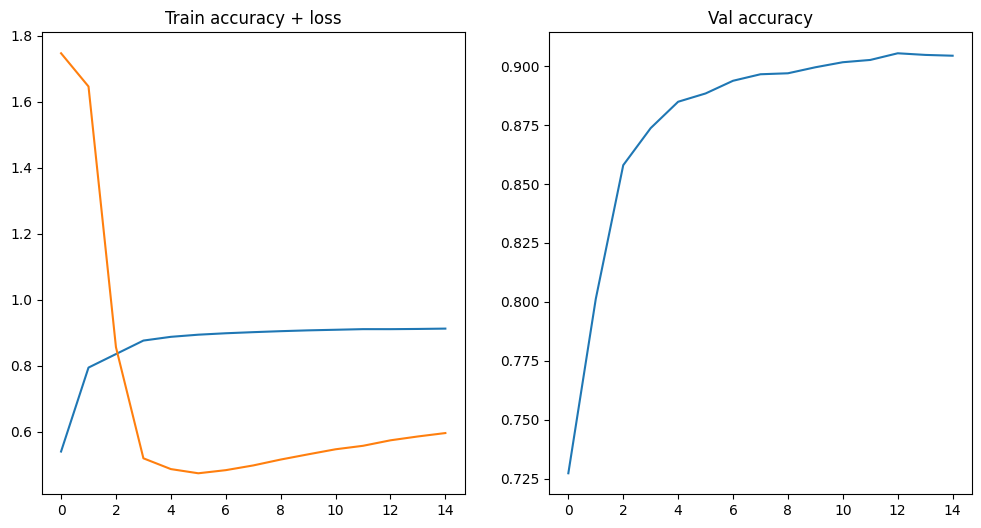

In [18]:
_, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axarr[0].plot(train_accuracies)
axarr[0].plot(train_losses)
axarr[0].set_title("Train accuracy + loss")
axarr[0].ticklabel_format(useOffset=False, style='plain')

axarr[1].plot(val_accuracies)
axarr[1].set_title("Val accuracy")
axarr[1].ticklabel_format(useOffset=False, style='plain')

plt.show()

### It is time to give a final run for our model and decide its quality.

Inferring on _test split_ is provided below with visualisation.

In [19]:
test_accuracy = obtain_accuracy_on(model, X_test, y_test)

print(f"Test accuracy is {test_accuracy * 100:.2f}%")

Test accuracy is 90.97%


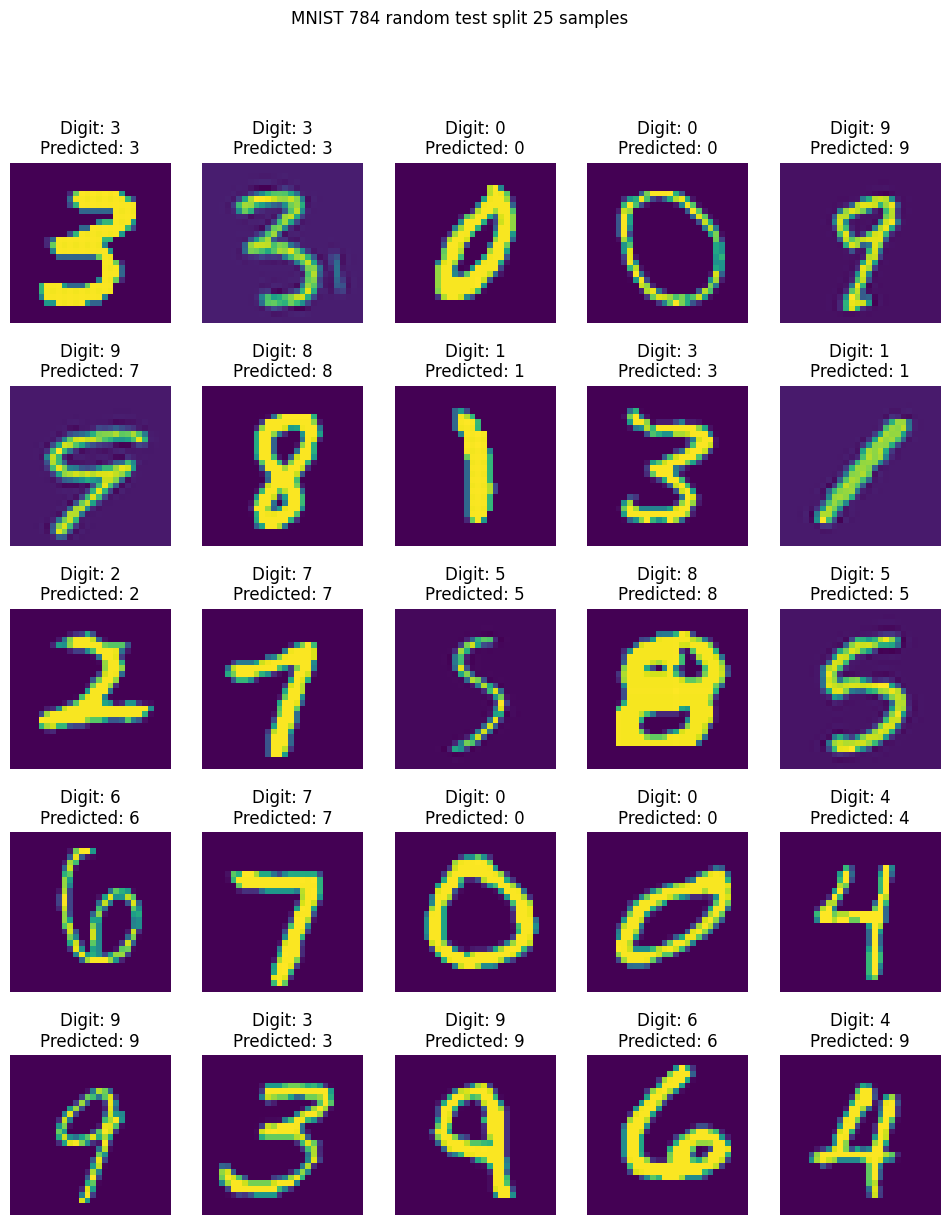

In [20]:
display_dataset(
    n_rows=5,
    n_cols=5,
    X=X_test,
    y=y_test,
    pred=np.argmax(model.forward(X_test / 255.0), axis=1),
    split_title="test split",
    figsize=(12,14),
)

### Handwritten dataset

And a small bonus point: let's take a look at manually generated images and see how our model behaves with such data.

In [21]:
def load_customdataset(mask: str) -> [np.ndarray, np.ndarray]:
    files = glob.glob(mask)
    n = len(files)

    X = np.zeros((n, 28*28))
    y = []

    for i, file in enumerate(files):
        y.append(os.path.dirname(file).split("/")[-1])
        X[i,:] = cv2.imread(file, cv2.IMREAD_GRAYSCALE).reshape((1,28*28))

    return X, y

In [22]:
X_handwritten, y_handwritten = load_customdataset("./dataset/*/*")
X_handwritten.shape

(10, 784)

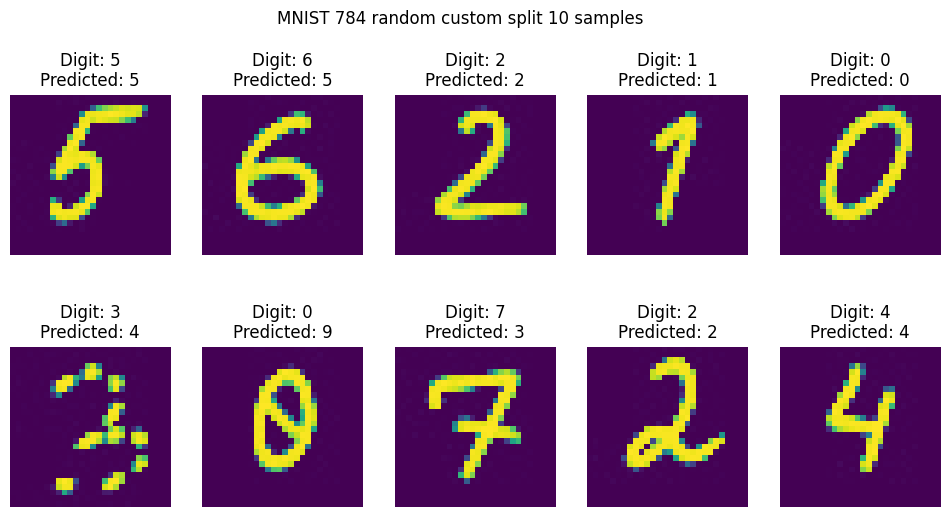

In [23]:
display_dataset(
    n_rows=2,
    n_cols=5,
    X=X_handwritten,
    y=y_handwritten,
    pred=np.argmax(model.forward(X_handwritten / 255.0), axis=1),
    split_title="custom split",
    figsize=(12,6),
)

Implemented model **indeed** learns the patterns and provides good results _(even though the dataset is simple)_.

A few thoughts on what can be explored next:
- fixing vanishing and exploding gradients
    - gradient clipping
    - gradient scaling